## 1. Imports

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

## 2. Read the dataset

In [3]:
purchase_history = pd.read_csv('dataset.csv')

In [4]:
purchase_history['timestamp'] = purchase_history['timestamp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f') + timedelta(hours=5, minutes=30))

## 3. User segmentation

### 3.1. Based on number of orders

In [47]:
purchase_history_agg = purchase_history.groupby('user_id').agg({"purchase_value":["mean", 'count']}).reset_index(col_level=1)
purchase_history_agg.columns = ['user_id', 'aov', 'n_order']

In [48]:
quantile_wise_order_df = purchase_history_agg['n_order'].quantile([i/10 for i in range(1, 11)])
quantile_wise_order_df = quantile_wise_order_df.reset_index()
quantile_wise_order_df.columns = ['quantile', 'n_orders']
quantile_wise_order_df

,quantile,n_orders
0,0.1,1.0
1,0.2,1.0
2,0.3,2.0
3,0.4,2.0
4,0.5,4.0
5,0.6,5.0
6,0.7,8.0
7,0.8,12.0
8,0.9,22.0
9,1.0,301.0


In [49]:
# Similar to the idea that we used while cohorting the users, now we look at the distribution of users
# into different quantiles and classify them into different classes/segments

# Here, we see that almost 90% users have total orders less than 22 and only 10% users have total orders greater than 22
# Further, lets classify users into 3 buckets based on total orders:

# Least frequent users  :       0 < total_orders <= 8  (Bottom 80%)
# Average frequent users:       8 < total_orders <= 22 (Next 20%)
# Most frequent users   :       22 < total_orders      (Top 10%)

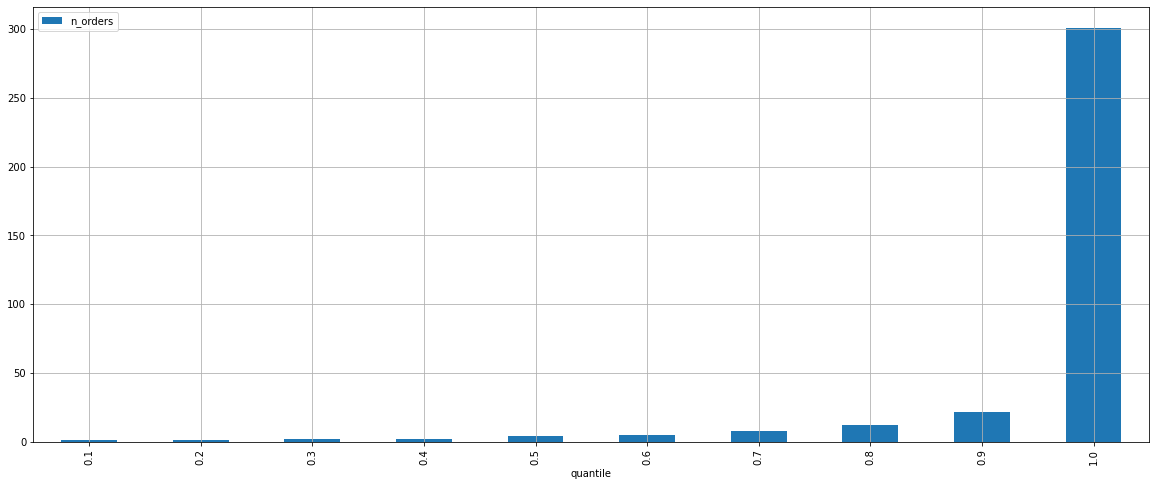

In [50]:
quantile_wise_order_df.plot.bar(x='quantile', y='n_orders', figsize=(20,8), grid=True);

### 3.2. Based on average purchase value

In [51]:
quantile_wise_aov_df = purchase_history_agg['aov'].quantile([i/10 for i in range(1, 11)])
quantile_wise_aov_df = quantile_wise_aov_df.reset_index()
quantile_wise_aov_df.columns = ['quantile', 'aov']
quantile_wise_aov_df

,quantile,aov
0,0.1,143.000000
1,0.2,183.333333
2,0.3,217.111111
3,0.4,250.693333
4,0.5,284.666667
5,0.6,323.941830
6,0.7,367.000000
7,0.8,434.700000
8,0.9,553.693060
9,1.0,5302.000000


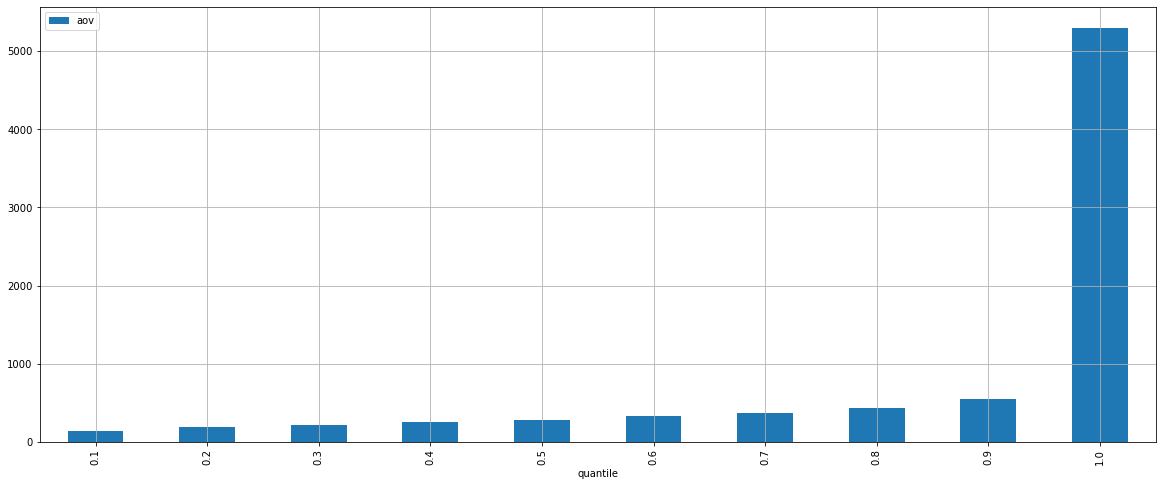

In [30]:
quantile_wise_aov_df.plot.bar(x='quantile', y='aov', figsize=(20,8), grid=True);

In [58]:
# Similar to what we have done above we can classify users into 3 segments:

# Low aov/gmv user    :       0 < aov <= 360   (Bottom 80%)
# Average aov/gmv user:       360 < aov <= 550 (Next 20%)
# High aov/gmv user   :       550 < aov        (Top 10%)

In [ ]:
# Similar to what we have done in the cohorting logic, we can also segment the users based on RFM

### 3.3. Based on RFM

In [77]:
max_timestamp = purchase_history["timestamp"].max()

# calculate the recency in days
purchase_history["recency"] = (max_timestamp - purchase_history["timestamp"]).dt.days

# Group the data by user
user_groups = purchase_history.groupby("user_id")

# Create a new DataFrame to hold the segmentation data
segmentation = pd.DataFrame()

# Add a column for the recency
segmentation["recency"] = user_groups["recency"].min()

# Add a column for the frequency
segmentation["frequency"] = user_groups["purchase_value"].count()

# Add a column for the monetary
segmentation["monetary"] = user_groups["purchase_value"].mean()

# Set the index of the DataFrame to be the user IDs
segmentation.reset_index(level=0, inplace=True)

In [78]:
# Define the quartile ranges for recency, frequency and monetary
r_quartile = pd.qcut(segmentation["recency"], q=3, labels=["Most Recent", "Mid Recent", "Least Recent"])
f_quartile = pd.qcut(segmentation["frequency"], q=3, labels=["Highly frequent", "Mid-Frequent", "Rare"])
m_quartile = pd.qcut(segmentation["monetary"], q=3, labels=["Highly Valuable", "Mid-Valuable","Not Valuable"])

# Add the quartile labels to the DataFrame
segmentation["r_quartile"] = r_quartile
segmentation["f_quartile"] = f_quartile
segmentation["m_quartile"] = m_quartile

In [79]:
segmentation.head(3)

,user_id,recency,frequency,monetary,r_quartile,f_quartile,m_quartile
0,0000602f168960c53835096f2daad506a80fcef2b4b13a...,25,1,132.000000,Mid Recent,Highly frequent,Highly Valuable
1,0001b82c569a333a80c48f2004827e4a8e5be5840fbd9b...,90,1,113.000000,Least Recent,Highly frequent,Highly Valuable
2,000700164cee77c05439c206a588b66fe734150ede585f...,1,24,196.958333,Most Recent,Rare,Highly Valuable


In [74]:
# Similar to what we discussed in the cohorting logic:

# For the purposes of this assignment, I am just writing the further steps in this approach in words rather than writing the code as the actual implimentation 
# will depend on the use case. In this approach we can assign a number with each of the element in classes of recency, frequency, monetary. Then, we can 
# assign the weights to the classes itself based on heuritic depending upon the use case.

# Now, we come up with an overall score for the user which will be a weighted sum of class_weight*element_value
# Once we get this overall score then we can create different cohorts based on this score.

# Example:
# Lets assume we assign equal weights to each of the classes (recency, frequency, monetary) of [1, 1, 1]
# Also, for simplicity we lets assume we assign the elements of these classes similar number 
# Most Recent -> 3,  Mid-Recent -> 2, Least Recent -> 1
# Highly frequent-> 3, Mid-Frequent -> 2, Rare -> 1
# and so on...

# Now to get the overall score for lets say user_id == '0001b82c569a333a80c48f2004827e4a8e5be5840fbd9b69ac0379e0de0d8dd7' (say u1)
# overall_score for u1 = 1*3 + 1*3 + 1*4 = 11

# Similarly we can get the score for all uses and then we can get the distribution of these scores.
# Based on the distribution and the use case, we can define different cohorts based on quantiles or binning logic

# Important note: We actual class weights will arrive from some heuristic or some business logic and is taken [1, 1, 1] in the example just for explanation

In [92]:
segmentation['r_score'] + segmentation['f_score']

TypeError: unsupported operand type(s) for +: 'Categorical' and 'Categorical'

In [114]:
recency_score_map = {"Most Recent":3, "Mid Recent":2, "Least Recent":1}
frequency_score_map = {"Highly frequent":3, "Mid-Frequent":2, "Rare":1}
monetory_score_map = {"Highly Valuable":3, "Mid-Valuable":2,"Not Valuable":1}

class_wt = {'r': 1, 'f': 1, 'm': 1}

segmentation['r_score'] = segmentation["r_quartile"].map(recency_score_map).astype(int)
segmentation['f_score'] = segmentation["f_quartile"].map(frequency_score_map).astype(int) 
segmentation['m_score'] = segmentation["m_quartile"].map(monetory_score_map).astype(int) 

segmentation['total_score'] = segmentation['r_score'].apply(lambda x: x*class_wt['r']) + segmentation['f_score'].apply(lambda x: x*class_wt['f']) + segmentation['m_score'].apply(lambda x: x*class_wt['m'])
segmentation.head(3)

,user_id,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,r_score,f_score,m_score,score,total_score
0,0000602f168960c53835096f2daad506a80fcef2b4b13a...,25,1,132.000000,Mid Recent,Highly frequent,Highly Valuable,2,3,3,8,8
1,0001b82c569a333a80c48f2004827e4a8e5be5840fbd9b...,90,1,113.000000,Least Recent,Highly frequent,Highly Valuable,1,3,3,7,7
2,000700164cee77c05439c206a588b66fe734150ede585f...,1,24,196.958333,Most Recent,Rare,Highly Valuable,3,1,3,7,7


In [115]:
rfm_score_quantiles = segmentation['total_score'].quantile([i/10 for i in range(1, 11)])
rfm_score_quantiles = rfm_score_quantiles.reset_index()
rfm_score_quantiles.columns = ['quantile', 'total_score']

rfm_score_quantiles

,quantile,total_score
0,0.1,5.0
1,0.2,5.0
2,0.3,5.0
3,0.4,6.0
4,0.5,6.0
5,0.6,6.0
6,0.7,7.0
7,0.8,7.0
8,0.9,8.0
9,1.0,9.0


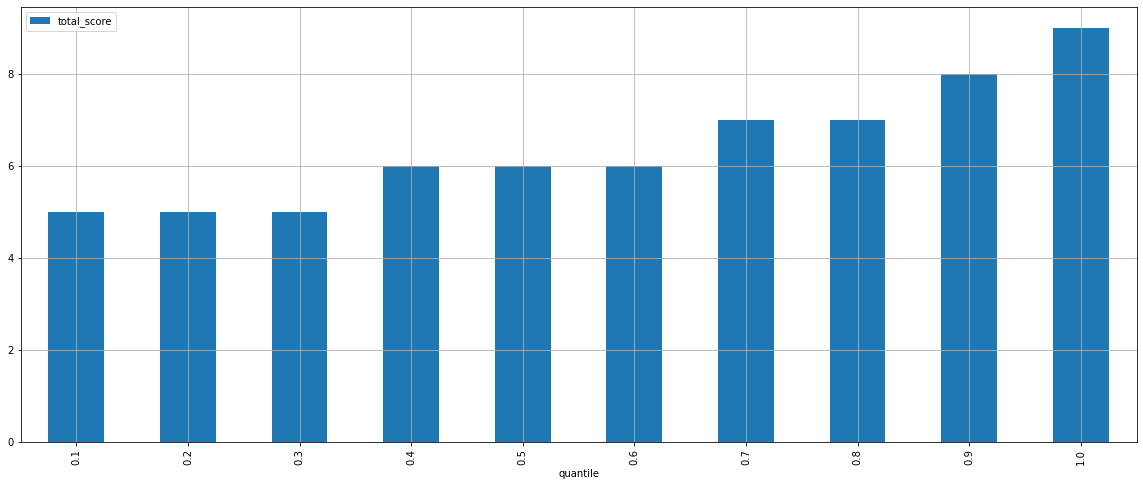

In [116]:
rfm_score_quantiles.plot.bar(x='quantile', y='total_score', figsize=(20,8), grid=True);

In [ ]:
# Following the same approach here also we can create 4 segments

# Low score user         :       0 < score <= 5    (Bottom 30%)
# Average score user     :       5 < score <= 7    (Next 30%)
# High score user        :       7 < score <=8     (Top 20%)
# Very High score user   :       8 < score         (Top 20%)

# Note: This is just an idea depending upon the use case we can create more number of classes and assign weights to individual classes